In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.utils import resample

In [32]:
A1 = pd.read_csv('Arrh1.csv')
A2 = pd.read_csv('Arrh2.csv')

In [36]:
A1['ln_k'] = np.log(A1['k [s-1]'])  
A1['1/T'] = 1 / A1['T [K]']  

x = A1[['1/T']]  
y = A1['ln_k']      
model = LinearRegression().fit(x, y)

gradient = model.coef_[0]
intercept = model.intercept_
y_pred = model.predict(x)

R = 8.314 
Ea = -gradient * (R / 1000)  

y_pred = model.predict(x)
r2 = r2_score(y, y_pred)


In [39]:
subset = A1[(A1['T [K]'] >= 950) & (A1['T [K]'] <= 1100)]

x_subset = subset[['1/T']]
y_subset = subset['ln_k']
model_subset = LinearRegression().fit(x_subset, y_subset)

gradient_subset = model_subset.coef_[0]
Ea_subset = -gradient_subset * (8.314 / 1000)  

y_pred_subset = model_subset.predict(x_subset)
r2_subset = r2_score(y_subset, y_pred_subset)

print(f"Full Dataset: Activation Energy (Ea) = {Ea:.2f} kJ/mol, R-squared = {r2:.3f}")
print(f"Subset Dataset: Activation Energy (Ea) = {Ea_subset:.2f} kJ/mol, R-squared = {r2_subset:.3f}")


Full Dataset: Activation Energy (Ea) = 148.65 kJ/mol, R-squared = 0.950
Subset Dataset: Activation Energy (Ea) = 265.74 kJ/mol, R-squared = 0.959


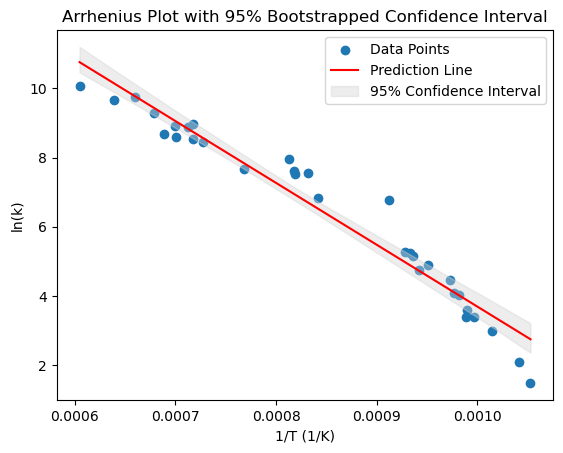

In [53]:
n_iterations = 1000
preds = []

for i in range(n_iterations):
    x_resample, y_resample = resample(x, y)
    model_bootstrap = LinearRegression().fit(x_resample, y_resample)
    preds.append(model_bootstrap.predict(x).flatten())

preds = np.array(preds)
lower = np.percentile(preds, 2.5, axis=0) 
upper = np.percentile(preds, 97.5, axis=0) 

plt.scatter(A1['1/T'], A1['ln_k'], label="Data Points")
plt.plot(A1['1/T'], y_pred, color='red', label='Prediction Line')
plt.fill_between(A1['1/T'], lower, upper, color='lightgrey', alpha=0.4, label="95% Confidence Interval")
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(k)')
plt.legend()
plt.title('Arrhenius Plot for Full D')
plt.show()



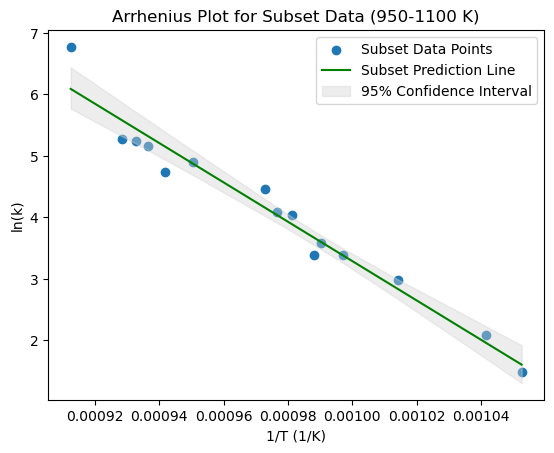

In [54]:
preds_subset = []

for i in range(n_iterations):
    x_resample, y_resample = resample(x_subset, y_subset)
    model_bootstrap_subset = LinearRegression().fit(x_resample, y_resample)
    preds_subset.append(model_bootstrap_subset.predict(x_subset).flatten())

preds_subset = np.array(preds_subset)
lower_subset = np.percentile(preds_subset, 2.5, axis=0)  
upper_subset = np.percentile(preds_subset, 97.5, axis=0)  

plt.scatter(x_subset, y_subset, label="Subset Data Points")
plt.plot(x_subset, y_pred_subset, color='green', label='Subset Prediction Line')
plt.fill_between(x_subset.values.flatten(), lower_subset, upper_subset, color='lightgrey', alpha=0.4, label="95% Confidence Interval")
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(k)')
plt.legend()
plt.title('Arrhenius Plot for Subset Data (950-1100 K)')
plt.show()

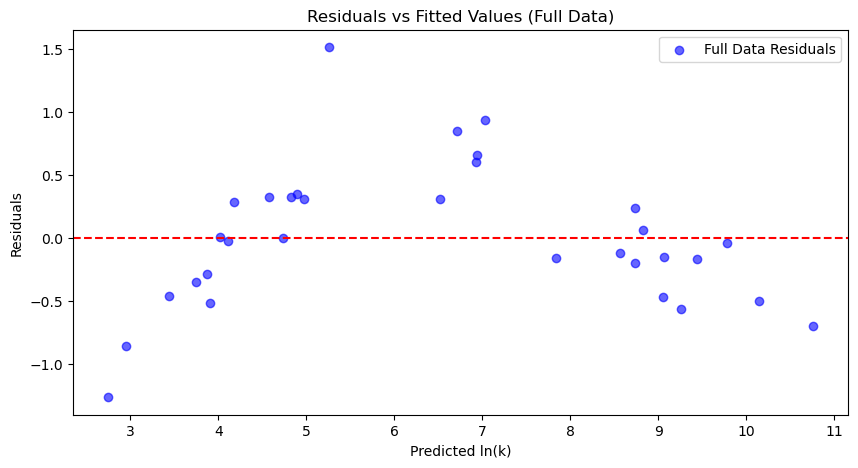

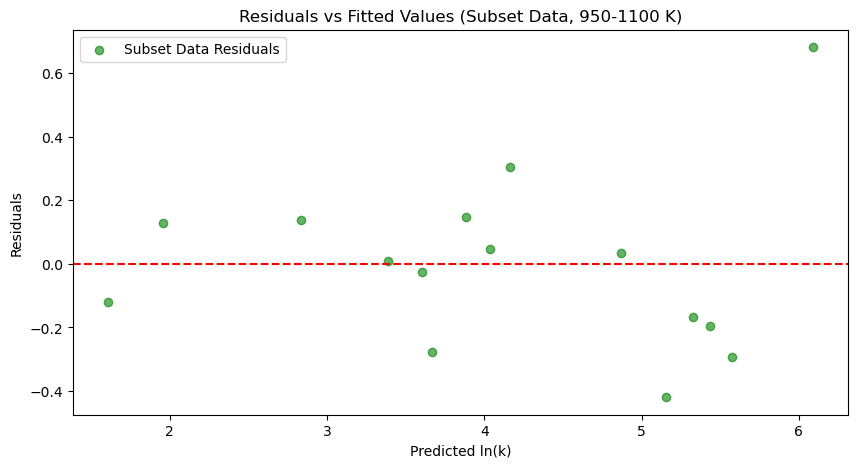

RMSE for Full Dataset: 0.553
RMSE for Subset Dataset: 0.263


In [62]:
residuals_full = y - y_pred
residuals_subset = y_subset - y_pred_subset

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals_full, color='blue', alpha=0.6, label='Full Data Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted ln(k)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Full Data)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_subset, residuals_subset, color='green', alpha=0.6, label='Subset Data Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted ln(k)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Subset Data, 950-1100 K)')
plt.legend()
plt.show()

rmse_full = np.sqrt(np.mean(residuals_full ** 2))
rmse_subset = np.sqrt(np.mean(residuals_subset ** 2))

print(f"RMSE for Full Dataset: {rmse_full:.3f}")
print(f"RMSE for Subset Dataset: {rmse_subset:.3f}")